# ***Computer Vision Final Project: Breast Cancer Tumor Classification***
## Section 1 Spring 2023
### Nicholas Lee, Nic Brathwaite, Amir Moayed

# Baseline Models

Possible features of benign tumors to look for in images: 
histologically benign [1]
	(adjective) Referring to a lesion that does not meet any criteria of malignancy – e.g., marked cellular atypia, mitosis, disruption of basement membranes, metastasize.

Consuming TFRecord data
Refer to the Loading TFRecords tutorial for an end-to-end example.

The tf.data API supports a variety of file formats so that you can process large datasets that do not fit in memory. For example, the TFRecord file format is a simple record-oriented binary format that many TensorFlow applications use for training data. The tf.data.TFRecordDataset class enables you to stream over the contents of one or more TFRecord files as part of an input pipeline.

### Setup

In [1]:
# Google packages
from google.colab import drive
from google.colab import files
from google.colab.patches import cv2_imshow

# base packages
import os
import warnings
import random
from datetime import date
import re
from tqdm.notebook import tqdm # progress bar library
import glob

# DS packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

# image packages
import PIL
import urllib
import cv2
import shutil
from skimage.color import rgb2gray
import skimage.io as skio
from skimage.feature import hog
from skimage import data, exposure

# ML packages
import scipy as sc
import sklearn as sk
import tensorflow
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, Callback , ModelCheckpoint
from tensorflow.keras.metrics import Accuracy,binary_crossentropy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline

In [2]:
pd.options.display.max_columns = 50
warnings.filterwarnings("ignore")

# Github connection

[See here for instructions](https://towardsdatascience.com/using-git-with-colab-via-ssh-175e8f3751ec)

Thinking of using for version control and final project submission

# Functions

In [3]:
# pickle object for later
import pickle

def pickler(ob, pklFileName):
  """ 
    Create pickle object to load later or in different environments for use later

    ob: object, python object intended to pickle
    pklFileName: string, name of the pickle file e.g. "User/content/drive/209/ThisDataFrame.pkl"
  """
  
  with open(pklFileName, "wb+") as f:
    pickle.dump(ob, f)

def load_pickles(pklFilePath):
  """
    path: string, path to object
    pklFileName: string, pickle file name with extension .pkl
  """

  return pd.read_pickle(pklFilePath)

# File Paths

In [4]:
# Mount google drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Paths
main_path = "/content/drive/MyDrive/"

project_path = "w281_final_project/"
project_path = "".join([main_path, project_path])

save_path = "".join([date.today().strftime('%Y%m%d'), "_baseline_models/"])
save_path = "".join([project_path, save_path])

# Sanity Check
print("project path: ", project_path)
print("save path: ", save_path)

project path:  /content/drive/MyDrive/w281_final_project/
save path:  /content/drive/MyDrive/w281_final_project/20230418_baseline_models/


# Load tensorflow dataset to use in models

In [6]:
# Load the saved dataset
#dataDir_fullSet = "/content/drive/MyDrive/w281_final_project/Data/tf_data/full_image_set"
# dataDir_40x = "/content/drive/MyDrive/w281_final_project/Data/tf_data/images_40X_20230325"
# dataDir_100x = ""
# dataDir_200x = ""
# dataDir_400x = ""

# dataset = tf.data.Dataset.load(dataDir_40x)

In [6]:
dataDir = "/content/drive/MyDrive/w281_final_project/Data/BreaKHis_v1/BreaKHis_v1/histology_slides/breast"


df = load_pickles(os.path.join("/content/drive/MyDrive/w281_final_project/Data/pickles", "metaData.pkl"))

# starting with 40x
df.query('MAGNIFICATION == "40"').reset_index(inplace=True, drop = True)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7909 entries, 0 to 7908
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   BIOPSY_PROCEDURE  7909 non-null   object
 1   TUMOR_CLASS       7909 non-null   object
 2   TUMOR_TYPE        7909 non-null   object
 3   YEAR              7909 non-null   object
 4   SLIDE_ID          7909 non-null   object
 5   MAGNIFICATION     7909 non-null   object
 6   SEQ               7909 non-null   object
 7   FULL_PATH         7909 non-null   object
 8   BASE_NAME         7909 non-null   object
dtypes: object(9)
memory usage: 556.2+ KB


,BIOPSY_PROCEDURE,TUMOR_CLASS,TUMOR_TYPE,YEAR,SLIDE_ID,MAGNIFICATION,SEQ,FULL_PATH,BASE_NAME
0,SOB,B,A,14,22549AB,100,004,/content/drive/MyDrive/w281_final_project/Data...,SOB_B_A-14-22549AB-100-004.png
1,SOB,B,A,14,22549AB,100,002,/content/drive/MyDrive/w281_final_project/Data...,SOB_B_A-14-22549AB-100-002.png
2,SOB,B,A,14,22549AB,100,003,/content/drive/MyDrive/w281_final_project/Data...,SOB_B_A-14-22549AB-100-003.png
3,SOB,B,A,14,22549AB,100,001,/content/drive/MyDrive/w281_final_project/Data...,SOB_B_A-14-22549AB-100-001.png
4,SOB,B,A,14,22549AB,100,007,/content/drive/MyDrive/w281_final_project/Data...,SOB_B_A-14-22549AB-100-007.png


<Axes: >

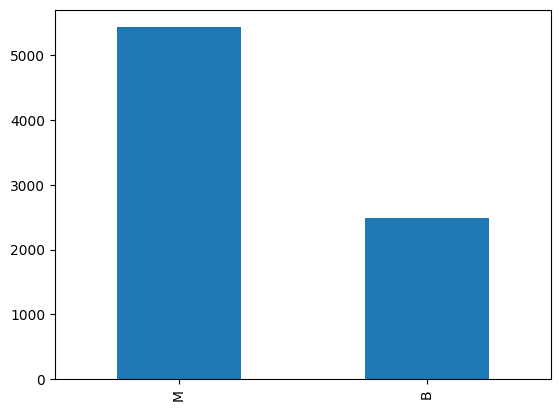

In [7]:
df.TUMOR_CLASS.value_counts().plot(kind='bar')

Data is highly imbalanced. Mecial applications usually have imbvalanced data with much fewer abnormal cases. 

In [8]:
#Filtering the data frame to benign and malignant for visualization
benign_df = df[df['TUMOR_CLASS'] == 'B']
malignant_df = df[df['TUMOR_CLASS'] == 'M']

Benign Samples

In [ ]:
#Plotting the benign samples
plt.figure(figsize = (30,10))
for i in range(0,40):
    plt.subplot(4,10,i+1)
    img = cv2.imread(benign_df['FULL_PATH'][i],1)
    plt.imshow(img)

Output hidden; open in https://colab.research.google.com to view.

Malignant Samples

In [ ]:
#Plotting the malignant samples
images = malignant_df['FULL_PATH'].values
plt.figure(figsize = (30,10))
for i in range(0,40):
    plt.subplot(4,10,i+1)
    img = cv2.imread(images[i],1)
    plt.imshow(img)

Output hidden; open in https://colab.research.google.com to view.

Findings:

From the above images there is very little to no difference between malignant and benign samples. The goal of our project is to create an ML model that is able to detect the presence of metastatic tissue from images.

In [9]:
#Creating a new data frame with the file loc as its index, label and class of the patients as its columns.
dff = df[['BASE_NAME','TUMOR_CLASS','FULL_PATH']].copy()
dff['class'] = dff['TUMOR_CLASS'].apply(lambda x: 1 if x =='M' else 0)
dff.set_index("BASE_NAME",inplace=True)

In [10]:
#Checking the data frame
dff.head(2)

,TUMOR_CLASS,FULL_PATH,class
BASE_NAME,,,
SOB_B_A-14-22549AB-100-004.png,B,/content/drive/MyDrive/w281_final_project/Data...,0
SOB_B_A-14-22549AB-100-002.png,B,/content/drive/MyDrive/w281_final_project/Data...,0


Using the data frame, we need to split it into train, test, and validation.
10% is kept aside as the test data, and 10% as validation data.
80% is taken as the training data.

In [11]:
#Performing the splitting
data_train_and_val, data_test = train_test_split(dff, test_size = 0.1, random_state = 47)
#Traing and val
data_train, data_val = train_test_split(data_train_and_val, test_size = 0.1, random_state = 47)

In [12]:
print("Training size :", data_train.shape)
print("Validation size :", data_val.shape)
print("Testing size :", data_test.shape)

Training size : (6406, 3)
Validation size : (712, 3)
Testing size : (791, 3)


In [13]:
data_train

,TUMOR_CLASS,FULL_PATH,class
BASE_NAME,,,
SOB_M_DC-14-3909-100-019.png,M,/content/drive/MyDrive/w281_final_project/Data...,1
SOB_M_DC-14-6241-100-017.png,M,/content/drive/MyDrive/w281_final_project/Data...,1
SOB_M_DC-14-20629-100-016.png,M,/content/drive/MyDrive/w281_final_project/Data...,1
SOB_M_MC-14-13413-100-040.png,M,/content/drive/MyDrive/w281_final_project/Data...,1
SOB_B_PT-14-21998AB-100-056.png,B,/content/drive/MyDrive/w281_final_project/Data...,0
...,...,...,...
SOB_M_DC-14-14926-100-016.png,M,/content/drive/MyDrive/w281_final_project/Data...,1
SOB_M_DC-14-20629-200-017.png,M,/content/drive/MyDrive/w281_final_project/Data...,1
SOB_B_A-14-22549AB-400-024.png,B,/content/drive/MyDrive/w281_final_project/Data...,0


Text(0.5, 1.0, 'Test set')

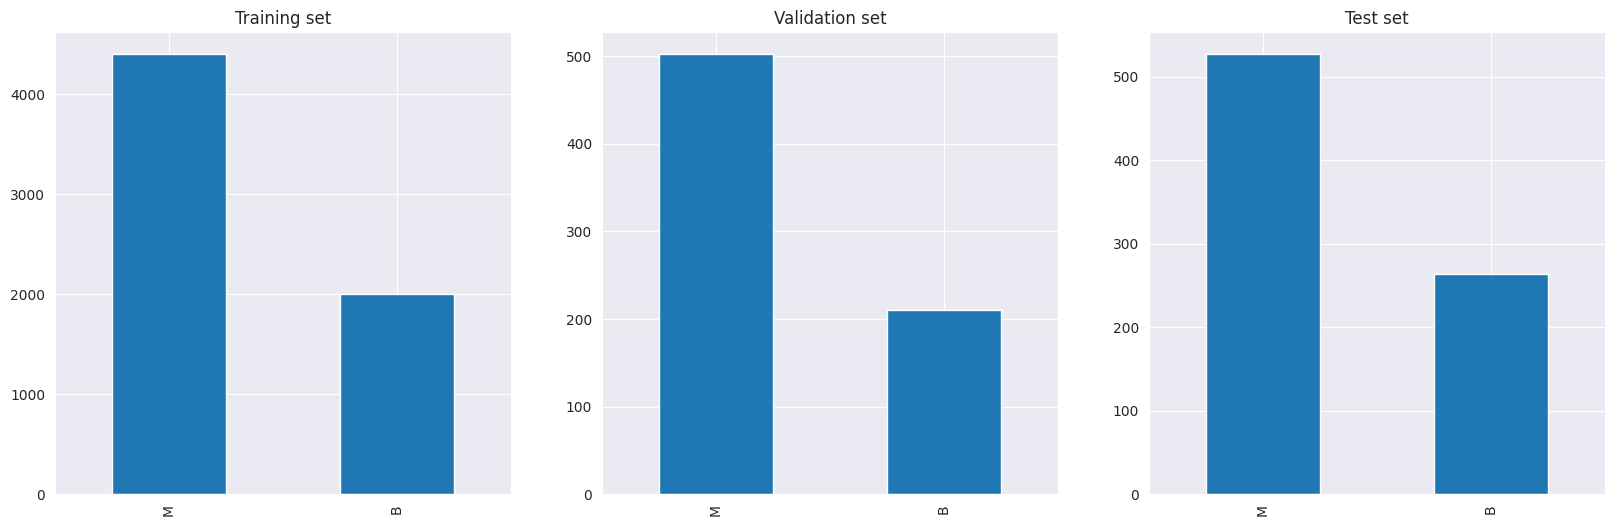

In [13]:
#Plotting
sns.set_style("darkgrid")
plt.figure(figsize = (20,6))
plt.subplot(1,3,1)
data_train.TUMOR_CLASS.value_counts().plot(kind='bar')
plt.title("Training set")
plt.subplot(1,3,2)
data_val.TUMOR_CLASS.value_counts().plot(kind='bar')
plt.title("Validation set")
plt.subplot(1,3,3)
data_test.TUMOR_CLASS.value_counts().plot(kind='bar')
plt.title("Test set")

Training , Validation and Testing data is pretty imbalanced which makes sense in the real world scenario. We will keep the validation and testing splits as is and oversample the minority class(Benign) in the training set. \

In [14]:
#Separating the benign and malignant patients from train data
train_has_cancer = data_train[data_train['class'] == 1]
train_has_no_cancer = data_train[data_train['class'] == 0]

In [15]:
train_has_cancer.shape

(4400, 3)

In [16]:
train_has_no_cancer.shape

(2006, 3)

In [17]:
#Upsampling the minority class by the size of majority class with replacement
train_has_no_cancer_upsample = resample(train_has_no_cancer, n_samples = len(train_has_cancer), random_state = 47, replace = True)

In [18]:

#Concatenating the upsampled minority class and the majority class
data_train = pd.concat([train_has_cancer,train_has_no_cancer_upsample])

Text(0.5, 1.0, 'Test set')

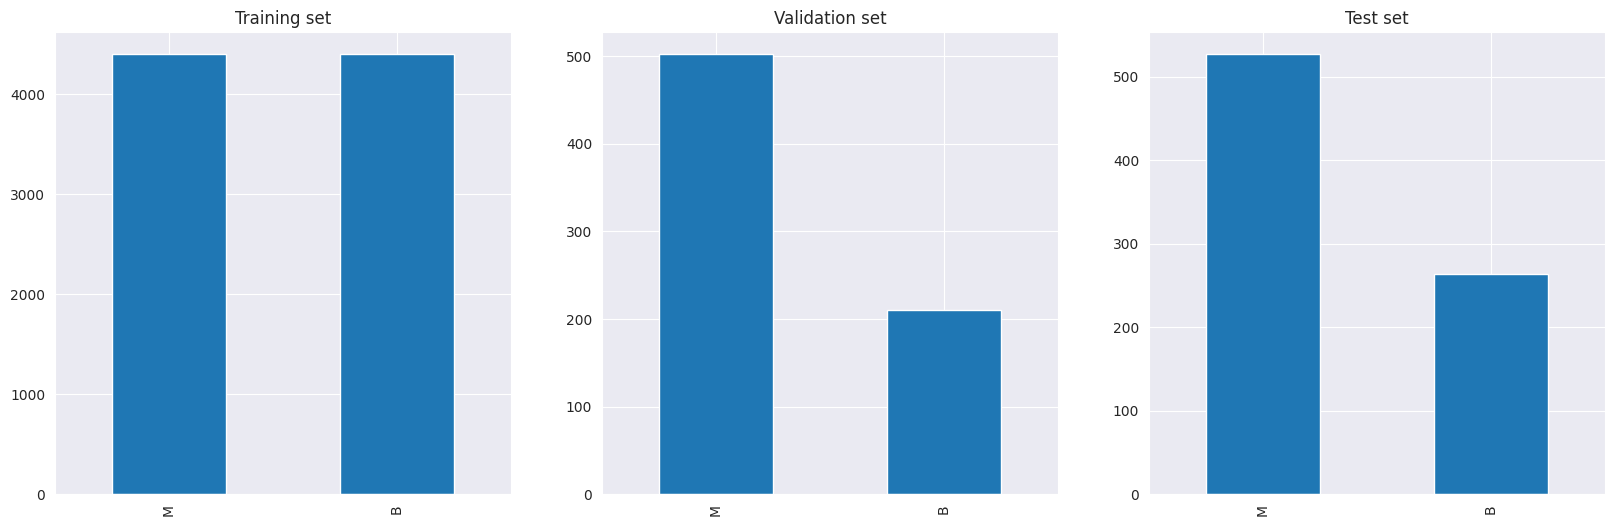

In [ ]:
#Plotting
sns.set_style("darkgrid")
plt.figure(figsize = (20,6))
plt.subplot(1,3,1)
data_train.TUMOR_CLASS.value_counts().plot(kind='bar')
plt.title("Training set")
plt.subplot(1,3,2)
data_val.TUMOR_CLASS.value_counts().plot(kind='bar')
plt.title("Validation set")
plt.subplot(1,3,3)
data_test.TUMOR_CLASS.value_counts().plot(kind='bar')
plt.title("Test set")

As expected the previous workflow balanced the training data by upsampling the amount of benign cases.

In [ ]:
os.makedirs("/content/drive/MyDrive/w281_final_project/Data/AmirData/Cancer_train")

In [ ]:
#Creating the directories to store images
os.makedirs("/content/drive/MyDrive/w281_final_project/Data/AmirData/Cancer_train")
os.makedirs("/content/drive/MyDrive/w281_final_project/Data/AmirData/Cancer_test")
os.makedirs("/content/drive/MyDrive/w281_final_project/Data/AmirData/Cancer_validation")
os.makedirs("/content/drive/MyDrive/w281_final_project/Data/AmirData/Cancer_train/benign")
os.makedirs("/content/drive/MyDrive/w281_final_project/Data/AmirData/Cancer_train/malignant")
os.makedirs("/content/drive/MyDrive/w281_final_project/Data/AmirData/Cancer_validation/benign")
os.makedirs("/content/drive/MyDrive/w281_final_project/Data/AmirData/Cancer_validation/malignant")
os.makedirs("/content/drive/MyDrive/w281_final_project/Data/AmirData/Cancer_test/benign")
os.makedirs("/content/drive/MyDrive/w281_final_project/Data/AmirData/Cancer_test/malignant")

In [19]:
df

,BIOPSY_PROCEDURE,TUMOR_CLASS,TUMOR_TYPE,YEAR,SLIDE_ID,MAGNIFICATION,SEQ,FULL_PATH,BASE_NAME
0,SOB,B,A,14,22549AB,100,004,/content/drive/MyDrive/w281_final_project/Data...,SOB_B_A-14-22549AB-100-004.png
1,SOB,B,A,14,22549AB,100,002,/content/drive/MyDrive/w281_final_project/Data...,SOB_B_A-14-22549AB-100-002.png
2,SOB,B,A,14,22549AB,100,003,/content/drive/MyDrive/w281_final_project/Data...,SOB_B_A-14-22549AB-100-003.png
3,SOB,B,A,14,22549AB,100,001,/content/drive/MyDrive/w281_final_project/Data...,SOB_B_A-14-22549AB-100-001.png
4,SOB,B,A,14,22549AB,100,007,/content/drive/MyDrive/w281_final_project/Data...,SOB_B_A-14-22549AB-100-007.png
...,...,...,...,...,...,...,...,...,...
7904,SOB,M,PC,15,190EF,40,016,/content/drive/MyDrive/w281_final_project/Data...,SOB_M_PC-15-190EF-40-016.png
7905,SOB,M,PC,15,190EF,40,010,/content/drive/MyDrive/w281_final_project/Data...,SOB_M_PC-15-190EF-40-010.png
7906,SOB,M,PC,15,190EF,40,007,/content/drive/MyDrive/w281_final_project/Data...,SOB_M_PC-15-190EF-40-007.png
7907,SOB,M,PC,15,190EF,40,009,/content/drive/MyDrive/w281_final_project/Data...,SOB_M_PC-15-190EF-40-009.png


In [19]:
df.set_index("BASE_NAME",inplace=True)

In [ ]:
#Training data
i = 1
for img in data_train.index:
    if img!=".DS_Store":
        target = df.loc[img,'TUMOR_CLASS']
        print(i)
        print(target)
        if target == 'M':
            label = 'malignant'
            
        else:  
            label = 'benign'      
        src = os.path.join(df.loc[img, 'FULL_PATH'])
        dest = os.path.join("/content/drive/MyDrive/w281_final_project/Data/AmirData/Cancer_train/",label, "image" + str(i)+".png")
        img1 = np.array(cv2.imread(src))
        cv2.imwrite(dest,img1)
        i = i+1
        

Streaming output truncated to the last 5000 lines.
6301
B
6302
B
6303
B
6304
B
6305
B
6306
B
6307
B
6308
B
6309
B
6310
B
6311
B
6312
B
6313
B
6314
B
6315
B
6316
B
6317
B
6318
B
6319
B
6320
B
6321
B
6322
B
6323
B
6324
B
6325
B
6326
B
6327
B
6328
B
6329
B
6330
B
6331
B
6332
B
6333
B
6334
B
6335
B
6336
B
6337
B
6338
B
6339
B
6340
B
6341
B
6342
B
6343
B
6344
B
6345
B
6346
B
6347
B
6348
B
6349
B
6350
B
6351
B
6352
B
6353
B
6354
B
6355
B
6356
B
6357
B
6358
B
6359
B
6360
B
6361
B
6362
B
6363
B
6364
B
6365
B
6366
B
6367
B
6368
B
6369
B
6370
B
6371
B
6372
B
6373
B
6374
B
6375
B
6376
B
6377
B
6378
B
6379
B
6380
B
6381
B
6382
B
6383
B
6384
B
6385
B
6386
B
6387
B
6388
B
6389
B
6390
B
6391
B
6392
B
6393
B
6394
B
6395
B
6396
B
6397
B
6398
B
6399
B
6400
B
6401
B
6402
B
6403
B
6404
B
6405
B
6406
B
6407
B
6408
B
6409
B
6410
B
6411
B
6412
B
6413
B
6414
B
6415
B
6416
B
6417
B
6418
B
6419
B
6420
B
6421
B
6422
B
6423
B
6424
B
6425
B
6426
B
6427
B
6428
B
6429
B
6430
B
6431
B
6432
B
6433
B
6434
B
6435
B
6436

In [ ]:
#Validation data
count = 0
for img in data_val.index:
    target = df.loc[img,'TUMOR_CLASS']
    print(count)
    print(target)
    if target == 'M':
        label = 'malignant'
    else:
        label = 'benign'
        
    src = os.path.join(df.loc[img, 'FULL_PATH'])
    dest = os.path.join("/content/drive/MyDrive/w281_final_project/Data/AmirData/Cancer_validation",label,img)
    shutil.copyfile(src,dest)
    count += 1

0
M
1
M
2
M
3
M
4
B
5
M
6
M
7
M
8
M
9
M
10
B
11
M
12
M
13
M
14
M
15
B
16
M
17
M
18
M
19
B
20
M
21
M
22
M
23
M
24
M
25
M
26
M
27
M
28
M
29
M
30
B
31
M
32
M
33
M
34
B
35
B
36
M
37
B
38
M
39
M
40
M
41
B
42
M
43
M
44
M
45
M
46
M
47
B
48
M
49
M
50
M
51
M
52
M
53
M
54
B
55
M
56
M
57
B
58
M
59
M
60
M
61
B
62
B
63
M
64
B
65
B
66
M
67
M
68
M
69
B
70
M
71
M
72
M
73
B
74
B
75
B
76
B
77
B
78
B
79
B
80
M
81
M
82
M
83
M
84
M
85
M
86
M
87
M
88
M
89
B
90
M
91
M
92
M
93
M
94
M
95
M
96
M
97
M
98
M
99
B
100
M
101
B
102
B
103
M
104
M
105
B
106
M
107
M
108
M
109
M
110
B
111
B
112
M
113
M
114
M
115
M
116
B
117
B
118
B
119
M
120
B
121
M
122
B
123
M
124
M
125
M
126
M
127
M
128
M
129
M
130
M
131
M
132
M
133
M
134
M
135
M
136
B
137
M
138
M
139
M
140
M
141
B
142
B
143
M
144
M
145
M
146
M
147
M
148
M
149
M
150
M
151
B
152
M
153
M
154
B
155
M
156
B
157
M
158
M
159
B
160
M
161
M
162
B
163
M
164
M
165
M
166
M
167
M
168
B
169
M
170
M
171
B
172
M
173
M
174
M
175
M
176
M
177
M
178
M
179
B
180
B
181
M
182
M
183
M
184
M


In [ ]:
#Testing data
count = 0
for img in data_test.index:
    target = df.loc[img,'TUMOR_CLASS']
    print(count)
    print(target)
    if target == 'M':
        label = 'malignant'
    else:
        label = 'benign'
        
    src = os.path.join(df.loc[img, 'FULL_PATH'])
    dest = os.path.join("/content/drive/MyDrive/w281_final_project/Data/AmirData/Cancer_test/",label,img)
    shutil.copyfile(src,dest)
    count += 1

0
M
1
M
2
M
3
M
4
M
5
M
6
M
7
M
8
M
9
M
10
B
11
M
12
M
13
B
14
M
15
M
16
M
17
B
18
M
19
M
20
B
21
M
22
M
23
B
24
M
25
M
26
M
27
M
28
B
29
M
30
B
31
M
32
M
33
M
34
M
35
B
36
B
37
B
38
B
39
M
40
M
41
M
42
M
43
M
44
M
45
M
46
M
47
B
48
B
49
B
50
M
51
M
52
M
53
M
54
M
55
M
56
B
57
B
58
M
59
M
60
B
61
M
62
B
63
M
64
M
65
M
66
M
67
M
68
M
69
B
70
M
71
M
72
B
73
M
74
M
75
M
76
B
77
M
78
B
79
M
80
M
81
M
82
B
83
M
84
M
85
M
86
M
87
M
88
B
89
M
90
B
91
B
92
M
93
B
94
B
95
B
96
M
97
M
98
M
99
B
100
M
101
B
102
M
103
M
104
M
105
B
106
M
107
B
108
M
109
B
110
M
111
M
112
B
113
M
114
M
115
M
116
B
117
M
118
B
119
M
120
B
121
M
122
B
123
B
124
M
125
M
126
M
127
B
128
B
129
M
130
M
131
M
132
M
133
M
134
M
135
M
136
M
137
M
138
M
139
B
140
M
141
M
142
M
143
M
144
M
145
M
146
B
147
B
148
B
149
B
150
M
151
M
152
B
153
M
154
M
155
M
156
B
157
M
158
B
159
M
160
M
161
M
162
B
163
M
164
B
165
M
166
M
167
M
168
M
169
M
170
M
171
B
172
B
173
B
174
M
175
M
176
B
177
B
178
M
179
M
180
M
181
B
182
B
183
M
184
M


In [ ]:
#Checking their lengths
print("Training Data:")
print(" ")
print("Benign:",len(os.listdir("/content/drive/MyDrive/w281_final_project/Data/AmirData/Cancer_train/benign/")))
print("Malignant::",len(os.listdir("/content/drive/MyDrive/w281_final_project/Data/AmirData/Cancer_train/malignant/")))
print(" ")
print("Validation Data")
print(" ")
print("Benign size:",len(os.listdir("/content/drive/MyDrive/w281_final_project/Data/AmirData/Cancer_validation/benign/")))
print("Malignant size :",len(os.listdir("/content/drive/MyDrive/w281_final_project/Data/AmirData/Cancer_validation/malignant/")))
print(" ")
print("Testing Data:")
print(" ")
print("Benign size :",len(os.listdir("/content/drive/MyDrive/w281_final_project/Data/AmirData/Cancer_test/benign/")))
print("Malignant size :",len(os.listdir("/content/drive/MyDrive/w281_final_project/Data/AmirData/Cancer_test/malignant/")))

Training Data:
 
Benign: 4400
Malignant:: 4400
 
Validation Data
 
Benign size: 210
Malignant size : 502
 
Testing Data:
 
Benign size : 264
Malignant size : 527


Image Data Generator¶
Reference: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
Generates batches of tensor image data with real-time data augmentation.
Thus CNN sees new set of images with different variation at each epoch.
One of the useful methods to prevent the model from Overfitting.

In [20]:
#Defining Image Data Generator
datagen = ImageDataGenerator(
    rotation_range=20,
    horizontal_flip=True,
    vertical_flip=True,
    rescale=1./255,
    shear_range=0.2,
    fill_mode='nearest',
    zoom_range=0.2)

Here the Image Data Generator is defined with following functions:
1. Random rotation by 20 degrees.
2. Horizontal flip.
3. Vertical flip.
4. Rescale image by its pixel value.
5. Randomly Zoom image by 20%.
6. Random shear by 20%.

In [21]:
#Setting up the images for image data generator
train_generation = datagen.flow_from_directory("/content/drive/MyDrive/w281_final_project/Data/AmirData/Cancer_train/",target_size=(128,128),batch_size = 32, class_mode="binary")
val_generation = datagen.flow_from_directory("/content/drive/MyDrive/w281_final_project/Data/AmirData/Cancer_validation/", target_size=(128,128), batch_size=32, class_mode="binary")

Found 8800 images belonging to 2 classes.
Found 712 images belonging to 2 classes.


CNN Architecture:
1. CNN architecture is defined using Conv2D layers and Maxpooling layers.
2. Dropout Layers are added to randomly turn off some neurons while training to prevent from overfitting.
3. Flatten layer is added at the end to form Dense Layers.
4. relu is used as activation in all the layers and Sigmoid as the activation in the output layer.

In [22]:
#Defining the base model
cancer_model = Sequential()

#First Layer
cancer_model.add(Conv2D(filters = 32, kernel_size = (3,3), input_shape = (128,128,3), activation = 'relu'))
cancer_model.add(MaxPooling2D(pool_size = (2,2)))

#Second Layer
cancer_model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'same',activation = 'relu'))
cancer_model.add(MaxPooling2D(pool_size = (2,2)))

#Third Layer
cancer_model.add(Conv2D(filters = 128, kernel_size = (3,3), padding = 'same', activation = 'relu'))
cancer_model.add(MaxPooling2D(pool_size = (2,2)))
cancer_model.add(Dropout(0.4))

#Fourth Layer
cancer_model.add(Conv2D(filters = 256, kernel_size = (3,3), padding = 'same', activation = 'relu'))
cancer_model.add(MaxPooling2D(pool_size = (2,2)))
cancer_model.add(Dropout(0.2))

#Flattening the layers
cancer_model.add(Flatten())

#Adding the dense layer
cancer_model.add(Dense(256, activation = 'relu'))
cancer_model.add(Dense(128, activation = 'relu'))
cancer_model.add(Dense(1, activation = 'sigmoid'))

cancer_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 63, 63, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 31, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 31, 31, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 128)      0

In [23]:
#Setting the learning rate to reduce gradually over the training period
lr_schedule = tensorflow.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=20*50,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tensorflow.keras.optimizers.Adam(lr_schedule)

In [24]:
#Compiling the model
cancer_model.compile(loss='binary_crossentropy', optimizer = get_optimizer(), metrics = ['accuracy'])
early_stop = EarlyStopping(monitor='val_loss',patience=5)
checkpoint = ModelCheckpoint("./Best_model/",save_best_only=True,)

Model Fit
1. Model is fitted using train and validation generators generated using Image DataGenerator.
2. Verbose is set to 1 to monitor accuracy and losses.
3. Model is trained for 200 epochs.
4. Early stopping and checkpoint are used as the call backs.

In [26]:
from datetime import datetime
t = datetime.now().strftime("%Y%m%d_%H%M%S")
export_path = "./models/soft-f1_{}".format(t)
cancer_model.save(export_path)
print("Model with macro soft-f1 was exported in this path: '{}'".format(export_path))

Model with macro soft-f1 was exported in this path: './models/soft-f1_20230418_131409'


In [27]:
from tensorflow import keras
cancer_model = keras.models.load_model(export_path)


In [28]:
#Model is fitted using train and validation generator for 200 epochs
history = cancer_model.fit(train_generation, validation_data=val_generation, epochs=20 ,
                 callbacks=[early_stop,checkpoint], verbose = 1)

Epoch 1/20
275/275 [==============================] - ETA: 0s - loss: 0.5330 - accuracy: 0.7462 

275/275 [==============================] - 3210s 12s/step - loss: 0.5330 - accuracy: 0.7462 - val_loss: 0.5714 - val_accuracy: 0.7809
Epoch 2/20
275/275 [==============================] - ETA: 0s - loss: 0.4774 - accuracy: 0.7984

275/275 [==============================] - 357s 1s/step - loss: 0.4774 - accuracy: 0.7984 - val_loss: 0.4084 - val_accuracy: 0.8413
Epoch 3/20
275/275 [==============================] - ETA: 0s - loss: 0.4462 - accuracy: 0.8116

275/275 [==============================] - 359s 1s/step - loss: 0.4462 - accuracy: 0.8116 - val_loss: 0.3898 - val_accuracy: 0.8567
Epoch 4/20
275/275 [==============================] - 348s 1s/step - loss: 0.4271 - accuracy: 0.8169 - val_loss: 0.3983 - val_accuracy: 0.8258
Epoch 5/20
275/275 [==============================] - ETA: 0s - loss: 0.4078 - accuracy: 0.8292

275/275 [==============================] - 358s 1s/step - loss: 0.4078 - accuracy: 0.8292 - val_loss: 0.3608 - val_accuracy: 0.8610
Epoch 6/20
275/275 [==============================] - 349s 1s/step - loss: 0.3960 - accuracy: 0.8328 - val_loss: 0.3669 - val_accuracy: 0.8596
Epoch 7/20
275/275 [==============================] - ETA: 0s - loss: 0.3684 - accuracy: 0.8427

275/275 [==============================] - 353s 1s/step - loss: 0.3684 - accuracy: 0.8427 - val_loss: 0.3454 - val_accuracy: 0.8652
Epoch 8/20
275/275 [==============================] - 354s 1s/step - loss: 0.3486 - accuracy: 0.8530 - val_loss: 0.3545 - val_accuracy: 0.8385
Epoch 9/20
275/275 [==============================] - ETA: 0s - loss: 0.3315 - accuracy: 0.8580

275/275 [==============================] - 343s 1s/step - loss: 0.3315 - accuracy: 0.8580 - val_loss: 0.3333 - val_accuracy: 0.8666
Epoch 10/20
275/275 [==============================] - 348s 1s/step - loss: 0.3111 - accuracy: 0.8653 - val_loss: 0.3490 - val_accuracy: 0.8511
Epoch 11/20
275/275 [==============================] - ETA: 0s - loss: 0.3048 - accuracy: 0.8733

275/275 [==============================] - 345s 1s/step - loss: 0.3048 - accuracy: 0.8733 - val_loss: 0.3150 - val_accuracy: 0.8708
Epoch 12/20
275/275 [==============================] - ETA: 0s - loss: 0.2750 - accuracy: 0.8801

275/275 [==============================] - 356s 1s/step - loss: 0.2750 - accuracy: 0.8801 - val_loss: 0.2962 - val_accuracy: 0.8792
Epoch 13/20
275/275 [==============================] - ETA: 0s - loss: 0.2624 - accuracy: 0.8890

275/275 [==============================] - 360s 1s/step - loss: 0.2624 - accuracy: 0.8890 - val_loss: 0.2766 - val_accuracy: 0.8834
Epoch 14/20
275/275 [==============================] - 346s 1s/step - loss: 0.2557 - accuracy: 0.8918 - val_loss: 0.2808 - val_accuracy: 0.8764
Epoch 15/20
275/275 [==============================] - 352s 1s/step - loss: 0.2405 - accuracy: 0.8976 - val_loss: 0.3269 - val_accuracy: 0.8666
Epoch 16/20
275/275 [==============================] - ETA: 0s - loss: 0.2327 - accuracy: 0.9041

275/275 [==============================] - 343s 1s/step - loss: 0.2327 - accuracy: 0.9041 - val_loss: 0.2584 - val_accuracy: 0.8820
Epoch 17/20
275/275 [==============================] - ETA: 0s - loss: 0.2219 - accuracy: 0.9094

275/275 [==============================] - 350s 1s/step - loss: 0.2219 - accuracy: 0.9094 - val_loss: 0.2518 - val_accuracy: 0.8989
Epoch 18/20
275/275 [==============================] - ETA: 0s - loss: 0.2186 - accuracy: 0.9097

275/275 [==============================] - 355s 1s/step - loss: 0.2186 - accuracy: 0.9097 - val_loss: 0.2389 - val_accuracy: 0.8919
Epoch 19/20
275/275 [==============================] - 354s 1s/step - loss: 0.2048 - accuracy: 0.9156 - val_loss: 0.2395 - val_accuracy: 0.8904
Epoch 20/20
275/275 [==============================] - 352s 1s/step - loss: 0.2024 - accuracy: 0.9165 - val_loss: 0.2504 - val_accuracy: 0.8890


In [29]:
t = datetime.now().strftime("%Y%m%d_%H%M%S")
export_path = "./models/soft-f1_{}".format(t)
cancer_model.save(export_path)
print("Model with macro soft-f1 was exported in this path: '{}'".format(export_path))

Model with macro soft-f1 was exported in this path: './models/soft-f1_20230418_160459'


In [ ]:
reloaded = tensorflow.keras.experimental.load_from_saved_model(export_path,
                                                       custom_objects={'KerasLayer':hub.KerasLayer})

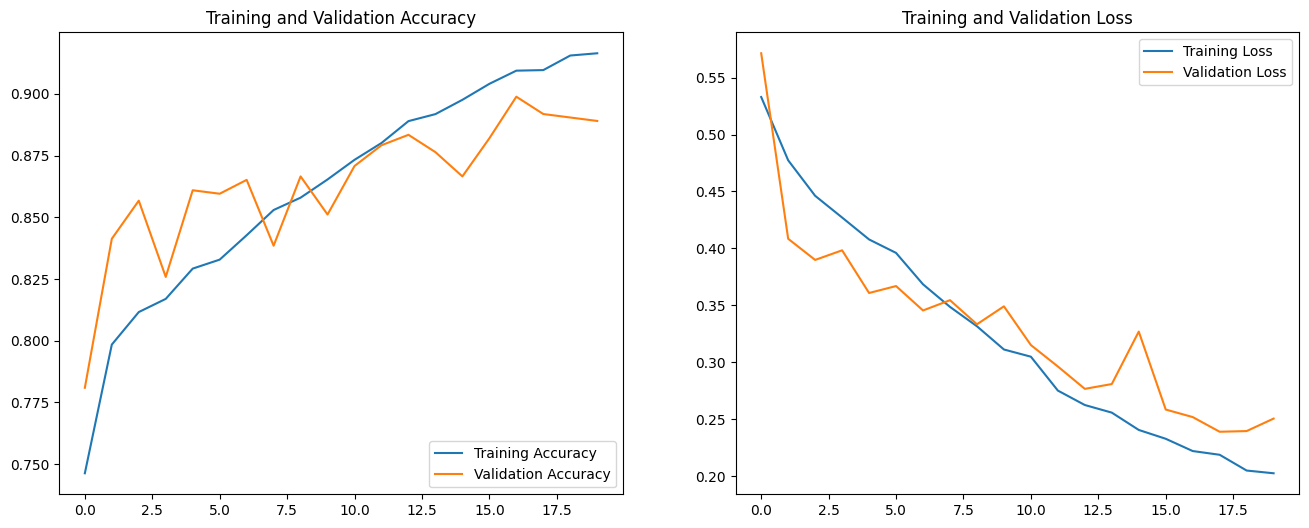

In [30]:
#Plotting the model results

#Getting the accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

#Getting the losses
loss = history.history['loss']
val_loss = history.history['val_loss']

#No of epochs it trained
epochs_range = history.epoch

#Plotting Training and Validation accuracy
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

#Plotting Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Evaluation on Test Data

In [31]:
#Loading the test data using Image Data Generator
test_gen = datagen.flow_from_directory("/content/drive/MyDrive/w281_final_project/Data/AmirData/Cancer_test/", target_size=(128,128), class_mode="binary", batch_size=1, shuffle=False)

Found 791 images belonging to 2 classes.


In [32]:
pred = cancer_model.evaluate(test_gen)

791/791 [==============================] - 207s 262ms/step - loss: 0.2227 - accuracy: 0.9077


In [33]:
#Let's Go ahead and test our model for few Images.

#Array to hold Input Images and their labels
test = []
labels = []

#Loading random 10 images
random_images = np.random.choice(data_test.index,10)

#For loop to read and store images
for i in random_images:
    #Finding their class to load from folder
    label = data_test.loc[i,"class"]
    labels.append(label)
    if label == 1:
        lab = "malignant"
    else:
        lab = "benign"
    #Creating path
    path = os.path.join("/content/drive/MyDrive/w281_final_project/Data/AmirData/Cancer_test/", lab, i)
    #reading image
    img = cv2.imread(path)
    #resizing to target shape
    img = cv2.resize(img,(128,128))
    #Making it an numpy array
    img = np.array(img)
    #Appending it to the list
    test.append(img)

#Making the list as numpy array
test = np.asarray(test)
#rescaling it by pixel value
test = test/255.

In [34]:
#Performing the prediction
pred = (cancer_model.predict(test) > 0.5).astype("int32")
#Flattening the list to form single dimensional list
pred = pred.flatten()

1/1 [==============================] - 1s 500ms/step


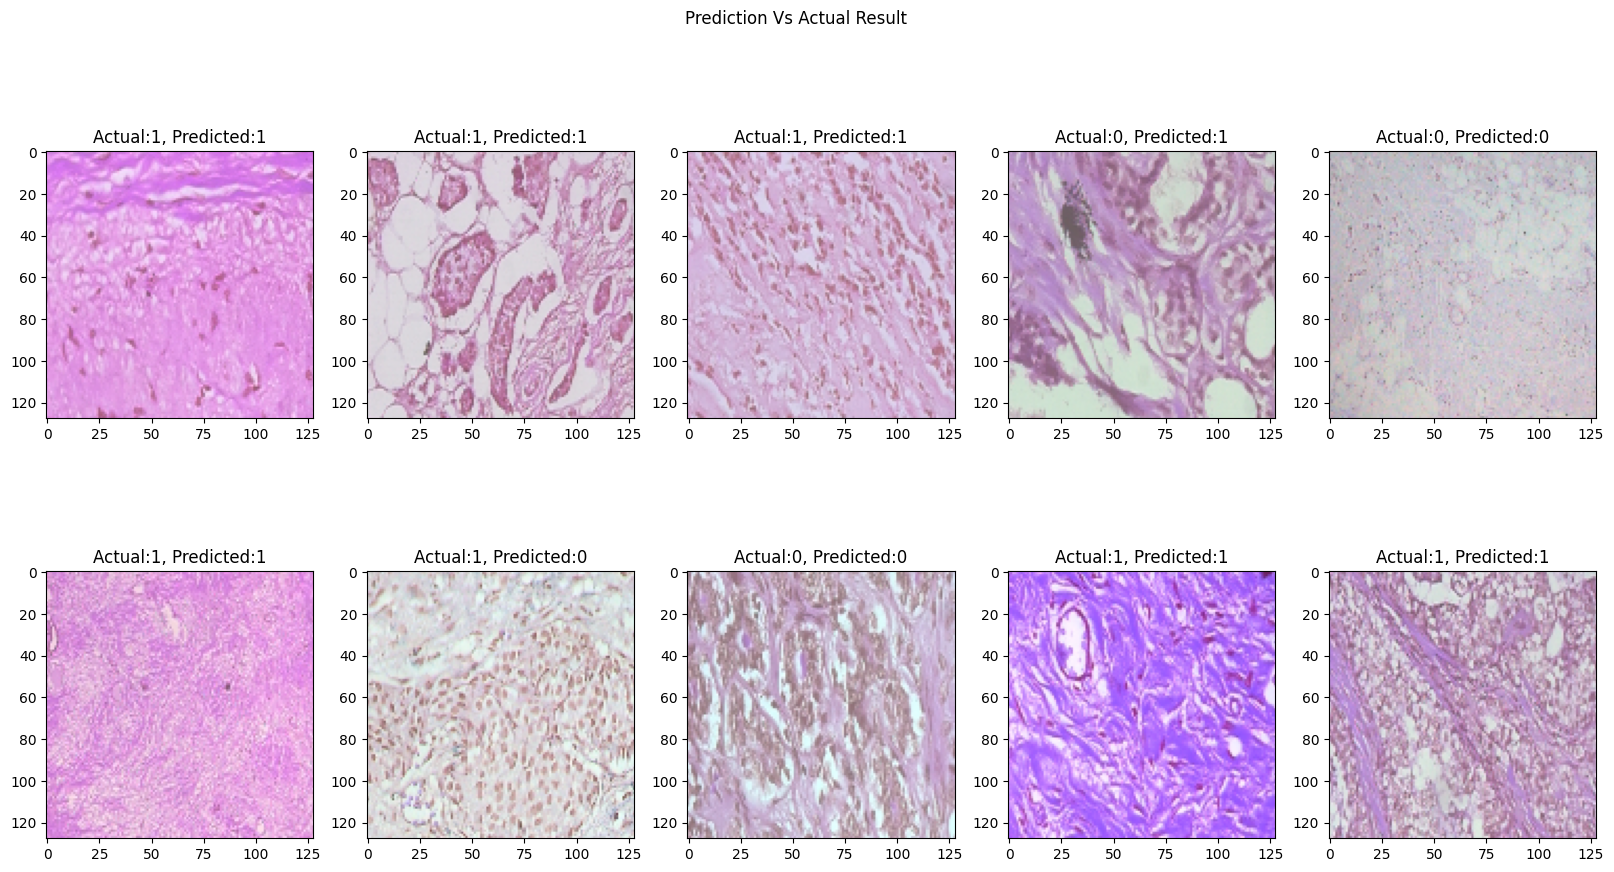

In [35]:
#Plotting results and actual prediction
plt.figure(figsize=(20,10))
plt.suptitle("Prediction Vs Actual Result")
for i in range(0,10):
    string = "Actual:" + str(labels[i]) + ", Predicted:" + str(pred[i])
    plt.subplot(2,5,i+1)
    plt.imshow(test[i])
    plt.title(string)

In [36]:
all_test = data_test.index
labels_2 = []
for i in all_test:
    #Finding their class to load from folder
    label = data_test.loc[i,"class"]
    labels_2.append(label)


In [43]:
test = []
#For loop to read and store images
for i in all_test:
    #Finding their class to load from folder
    label = data_test.loc[i,"class"]
    labels.append(label)
    if label == 1:
        lab = "malignant"
    else:
        lab = "benign"
    #Creating path
    path = os.path.join("/content/drive/MyDrive/w281_final_project/Data/AmirData/Cancer_test/", lab, i)
    #reading image
    img = cv2.imread(path)
    #resizing to target shape
    img = cv2.resize(img,(128,128))
    #Making it an numpy array
    img = np.array(img)
    #Appending it to the list
    test.append(img)

#Making the list as numpy array
test = np.asarray(test)
#rescaling it by pixel value
test = test/255.

#Performing the prediction
pred = (cancer_model.predict(test) > 0.5).astype("int32")
#Flattening the list to form single dimensional list
pred = pred.flatten()

25/25 [==============================] - 7s 265ms/step


In [37]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('True Negatives: ', cm[0][0])
  print('False Positives: ', cm[0][1])
  print('False Negatives: ', cm[1][0])
  print('True Positives: ', cm[1][1])
  print('Total Malignant Cases: ', np.sum(cm[1]))

  

True Negatives:  180
False Positives:  84
False Negatives:  52
True Positives:  475
Total Malignant Cases:  527


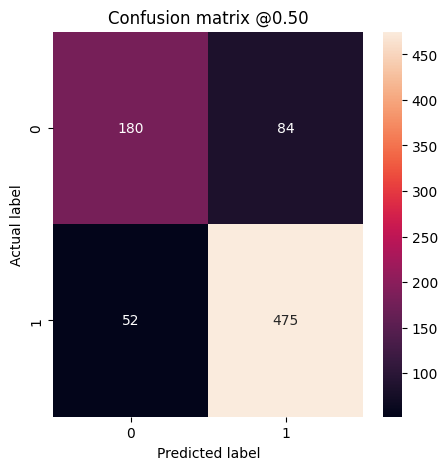

In [46]:
plot_cm(labels_2, pred, p=0.5)

In [39]:
t = datetime.now().strftime("%Y%m%d_%H%M%S")
export_path = "./models/soft-f1_{}".format(t)
cancer_model.save(export_path)
print("Model with macro soft-f1 was exported in this path: '{}'".format(export_path))

Model with macro soft-f1 was exported in this path: './models/soft-f1_20230418_161756'


In [44]:
labels_2

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,


In [45]:
pred

array([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1,